# Importações

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

#from wordcloud import WordCloud

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.chunk import tree2conlltags

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wferreira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wferreira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wferreira\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wferreira\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\wferreira\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\wferreira\AppData\Roaming\nltk_data...
[nltk_data]   Pack

# Coleta de Dados

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/paulafortuna/Portuguese-Hate-Speech-Dataset/master/2019-05-28_portuguese_hate_speech_binary_classification.csv')
df.head()

,text,hatespeech_comb,hatespeech_G1,annotator_G1,hatespeech_G2,annotator_G2,hatespeech_G3,annotator_G3
0,@__andrea__b \nO cara vive em outro mundo\nNão...,1,1,A,1.0,V,0,E
1,@_carmeloneto Estes incompetentes não cuidam n...,0,1,D,0.0,V,0,C
2,@_carmeloneto \nOs 'cumpanhero' quebraram toda...,0,1,A,0.0,B,0,E
3,@_GlitteryKisses é isso não conseguem pensar n...,0,0,C,0.0,V,0,D
4,@_iglira bom dia macaco branco haha,1,0,A,1.0,I,1,E


# Pré-processamento

## 1 Cleaning

In [3]:
import re
from bs4 import BeautifulSoup

def removeLinks(instancia):
    return re.sub(r"http\S+", "", instancia).lower()

def removePunctuation(instancia):
    return instancia.replace('.','') \
        .replace(',','') \
        .replace(';','') \
        .replace('-','') \
        .replace(':','') \
        .replace('(','') \
        .replace(')','')

def removeHTMLTags(instancia):
    return BeautifulSoup(instancia, 'html.parser').get_text()

def removeNonLettersAndNumbers(instancia):
    return re.sub(r"[^a-zA-Zà-úÀ-Ú0-9 ]", "", instancia.lower())

def removeSpacesFromCorners(instancia):
    return instancia.strip(" ").strip()

def cleanText(instancia):
    instancia = removeLinks(instancia)
    instancia = removePunctuation(instancia)
    instancia = removeHTMLTags(instancia)
    instancia = removeNonLettersAndNumbers(instancia)
    instancia = removeSpacesFromCorners(instancia)
    return instancia

## 2 Tokenization

In [11]:
def tokenizeText(instancia):
    '''
    Recebe o texto e retorna uma lista de tokens.
    '''
    return nltk.tokenize.TweetTokenizer().tokenize(instancia)

## 3 Stemming

In [4]:
nltk.download('rslp')
def stemText(instancia):
    '''
    Recebe uma lista de termos e retorna uma lista stemada.
    '''
    stemmer = nltk.stem.RSLPStemmer()
    words = []
    for w in instancia:
        words.append(stemmer.stem(w))
    return words

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\wferreira\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping stemmers\rslp.zip.


## 4 Lemmatization

In [5]:
from nltk.stem import WordNetLemmatizer
lematizador = WordNetLemmatizer()

def lemmatizeText(instancia):
    '''
    Recebe uma lista de termos e retorna uma lista lematizada.
    '''
    words = []
    for word in instancia:
        words.append(lematizador.lemmatize(word))
    return words

## 5 Removing STOPWORDS

In [8]:
def removeStopWords(instancia):
    '''
    Recebe uma lista de termos e retorna uma lista
    com stopwords removidas.
    '''
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [i for i in instancia if not i in stopwords]
    return " ".join(words)

## 6 Applying Techniques

In [12]:
from tqdm import tqdm
tqdm.pandas()

def preprocessingText(data):
    data['clean_text'] = data.progress_apply(lambda row: cleanText(row['text']), axis=1)
    data['tokenized'] = data.progress_apply(lambda row: tokenizeText(row['clean_text']), axis=1)
    data['stemmed'] = data.progress_apply(lambda row: stemText(row['tokenized']), axis=1)
    data['lemmatized'] = data.progress_apply(lambda row: lemmatizeText(row['stemmed']), axis=1)
    data['processed_text'] = data.progress_apply(lambda row: removeStopWords(row['lemmatized']), axis=1)
    return data

In [13]:
df = preprocessingText(df)

100%|██████████| 5670/5670 [00:00<00:00, 10392.67it/s]


### 6.1 Tratamentos adicionais

In [14]:
def list_to_text(instancia):
    words = [i for i in instancia]
    return " ".join(words)

def convert_to_text(data):
    data['tokenized'] = data.progress_apply(lambda row: list_to_text(row['tokenized']), axis=1)
    data['stemmed'] = data.progress_apply(lambda row: list_to_text(row['stemmed']), axis=1)
    data['lemmatized'] = data.progress_apply(lambda row: list_to_text(row['lemmatized']), axis=1)
    return data

df = convert_to_text(df)

100%|██████████| 5670/5670 [00:00<00:00, 333049.10it/s]


### 6.2 Remove palavras raras

In [15]:
def remove_rare_words(dataset, columns):
    for column in columns:
        rare_words = pd.Series(" ".join(dataset[column]).split()).value_counts()
        rare_words = rare_words[rare_words <= 2]
        dataset[column] = dataset[column].apply(lambda x: " ".join([i for i in x.split() if i not in  rare_words.index]))
    return dataset

df = remove_rare_words(df, columns=['clean_text','tokenized','stemmed','lemmatized','processed_text'])

df[['text','clean_text', 'tokenized', 'stemmed', 'lemmatized', 'processed_text']].head(3)

,text,clean_text,tokenized,stemmed,lemmatized,processed_text
0,@__andrea__b \nO cara vive em outro mundo\nNão...,o cara vive em outro no mundo são os que as suas,o cara vive em outro no mundo são os que as suas,o car viv em outr no mund são os que favel vi ...,o car viv em outr no mund são o que favel vi a...,car viv outr mund favel vi fortal
1,@_carmeloneto Estes incompetentes não cuidam n...,carmeloneto estes não nem do povo brasileiro e...,carmeloneto estes não nem do povo brasileiro e...,carmelonet est não cuid nem do pov brasil e ne...,carmelonet est não cuid nem do pov brasil e ne...,carmelonet est cuid pov brasil pouc refugi aqu...
2,@_carmeloneto \nOs 'cumpanhero' quebraram toda...,carmeloneto os todas as,carmeloneto os todas as,carmelonet os quebr tod as regr,carmelonet o quebr tod a regr,carmelonet quebr tod regr


## Visualizando labels Disponíveis

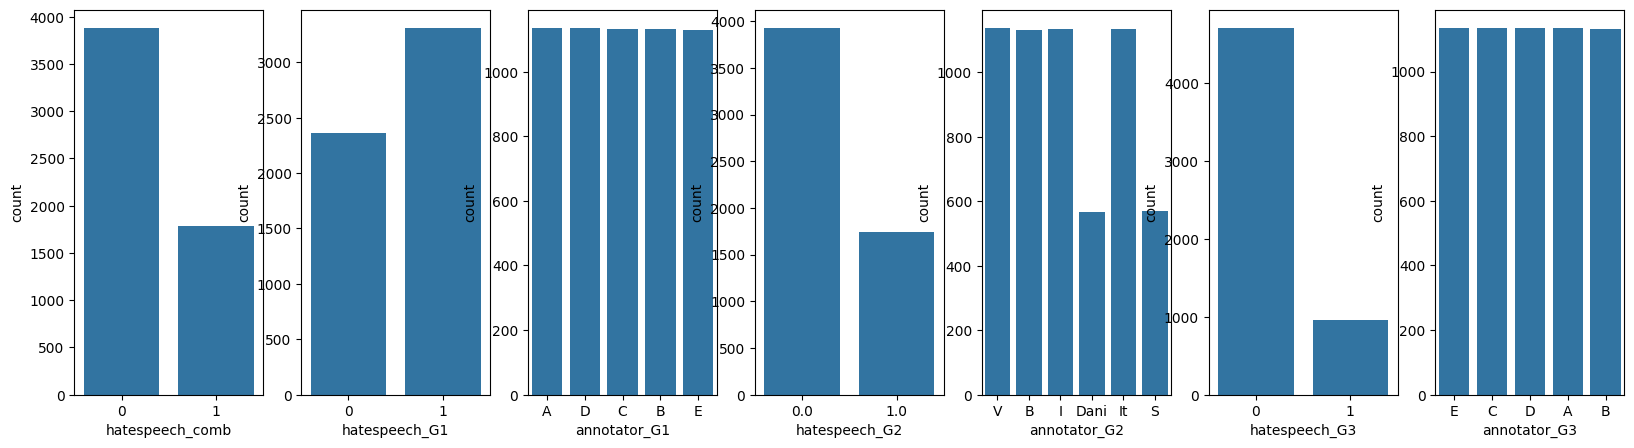

In [16]:
columns = ['hatespeech_comb', 'hatespeech_G1', 'annotator_G1','hatespeech_G2', 'annotator_G2', 'hatespeech_G3', 'annotator_G3']

plt.figure(figsize=(20,5))

number_plots = len(columns)

for index, value in enumerate(columns):
    plt.subplot(1, number_plots, index+1)
    sns.countplot(x=columns[index],data=df);

# Análise do Dataset

## Classe/Target
### Para este trabalho, adotaremos como label a feature 'hatespeech_comb' como a classe para tarefas de predições de comentários hate e no-hate, por representar a classificação agregada de cada instância (texto) na nossa base de dados.

hatespeech_comb
0    3882
1    1788
Name: count, dtype: int64


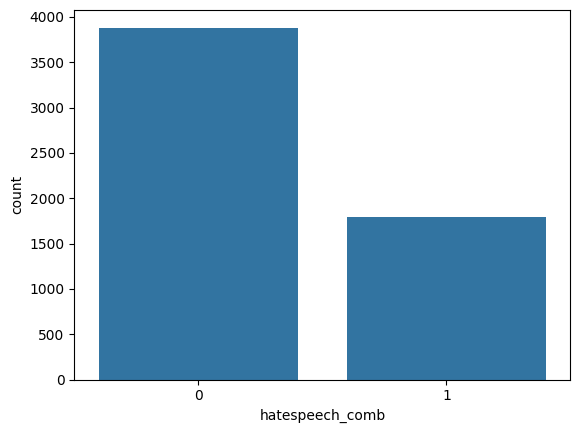

In [18]:
print(df['hatespeech_comb'].value_counts())
sns.countplot(x='hatespeech_comb',data=df);

## Features

### Para nossas features, geramos a partir da coluna text, onde tinhamos os texto brutos extraídos da base de dados, novas colunas como:

- clean_text: representando a limpeza com retirada de ruídos: @, pontuações, links e símbolos
- tokenized: texto em lista de termos
- stemming: palavras reduzidas ao seu radical
- lemmatization: o lema raíz do termo
- stopwords: remoção de palavras muito frequentes

In [19]:
df[['text','clean_text', 'tokenized', 'stemmed', 'lemmatized', 'processed_text']].head(3)

,text,clean_text,tokenized,stemmed,lemmatized,processed_text
0,@__andrea__b \nO cara vive em outro mundo\nNão...,o cara vive em outro no mundo são os que as suas,o cara vive em outro no mundo são os que as suas,o car viv em outr no mund são os que favel vi ...,o car viv em outr no mund são o que favel vi a...,car viv outr mund favel vi fortal
1,@_carmeloneto Estes incompetentes não cuidam n...,carmeloneto estes não nem do povo brasileiro e...,carmeloneto estes não nem do povo brasileiro e...,carmelonet est não cuid nem do pov brasil e ne...,carmelonet est não cuid nem do pov brasil e ne...,carmelonet est cuid pov brasil pouc refugi aqu...
2,@_carmeloneto \nOs 'cumpanhero' quebraram toda...,carmeloneto os todas as,carmeloneto os todas as,carmelonet os quebr tod as regr,carmelonet o quebr tod a regr,carmelonet quebr tod regr


## Counting Words

In [21]:
# import CountVectorizer for counting number of times each word occurs
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
count_matrix = cv.fit_transform(df.processed_text)

count_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [23]:
# create dataframe
word_count = pd.DataFrame(cv.get_feature_names_out(), columns = ['processed_text'])
# sum the presence of terms and turn it into a list
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
# 200 palavras mais usadas

#list(word_count[95:105]['processed_text'])

## Analisando 3 tipos de tratamento de texto

- clean_text: limpeza 
- lemmatizatized: limpeza + stemm + lemm
- processed_text: limpeza + stemm + lemm + removing stopwords

## Divisão em treino e teste

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier

X_train,X_test,y_train,y_test = train_test_split(df["text"],df["hatespeech_comb"], test_size = 0.25,random_state= 42,stratify=df["hatespeech_comb"])
# X_train,X_test,y_train,y_test = train_test_split(df["clean_text"],df["hatespeech_comb"], test_size = 0.25,random_state= 42,stratify=df["hatespeech_comb"])
# X_train,X_test,y_train,y_test = train_test_split(df["lemmatized"],df["hatespeech_comb"], test_size = 0.25,random_state= 42,stratify=df["hatespeech_comb"])
# X_train,X_test,y_train,y_test = train_test_split(df["processed_text"],df["hatespeech_comb"], test_size = 0.25,random_state= 42,stratify=df["hatespeech_comb"])

## Extração de Características: BagOfWords

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

vt = CountVectorizer(analyzer="word")
X_train_count = vt.fit_transform(X_train)
X_test_count = vt.transform(X_test)

## Classificação: Árvore de Decisão

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [50, 10, 150],
             'max_depth': [5, 10, None],
             'min_samples_split': [5, 10, 15],
             'min_samples_leaf': [1, 2, 5, 10],
             'bootstrap': [True, False]}
rf = RandomForestClassifier()
rf_model_cv = GridSearchCV(rf,parameters,cv = 5,n_jobs = -1)
rf_model_cv.fit(X_train_count,y_train)
rf_model_cv.best_params_

In [27]:
best_params_ = {'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 150}

best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 150}

## Pipeline RandomForestClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

In [46]:
n_estimators = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
max_depth = [5, 10, None]
min_samples_split = [5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10, 20]

for i in range(len(parametros)):
    print(parametros[i:i+2])

[10, 20]
[20, 30]
[30, 40]
[40, 50]
[50, 60]
[60, 70]
[70, 80]
[80]


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df["text"],df["hatespeech_comb"], test_size = 0.25,random_state= 42,stratify=df["hatespeech_comb"])

for i in range(5):
    parameters = {'max_features': ('auto','sqrt'),
                'n_estimators': [50, 10, 150],
                'max_depth': [5, 10, None],
                'min_samples_split': [5, 10, 15],
                'min_samples_leaf': [1, 2, 5, 10],
                'bootstrap': [True, False]}
    rf = RandomForestClassifier()
    rf_model_cv = GridSearchCV(rf,parameters,cv = 5,n_jobs = -1)
    rf_model_cv.fit(X_train_count,y_train)
    rf_model_cv.best_params_

In [28]:
import json

In [41]:
best_params_list = [best_params_, best_params_]

In [43]:
with open('best_params_rf.json', 'w', encoding='utf-8') as f:
    # Converte cada item para uma string JSON com indentação de 2 espaços e escreve no arquivo
    f.write(json.dumps(best_params_list, indent=2, ensure_ascii=False))
    # Adiciona uma quebra de linha após cada item